In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
origin = (900,400)
end = (40,400)

In [21]:
y_trajectory = list(range(40,901))
x_trajectory = [400]*len(y_trajectory)
dist = list(range(len(y_trajectory)))

In [22]:
dic = {'x':x_trajectory,'y':y_trajectory,'dist':dist}

In [25]:
df = pd.DataFrame(dic)

In [26]:
df

,x,y,dist
0,400,40,0
1,400,41,1
2,400,42,2
3,400,43,3
4,400,44,4
...,...,...,...
856,400,896,856
857,400,897,857
858,400,898,858
859,400,899,859


[(0.0, 800.0), (0.0, 1000.0)]

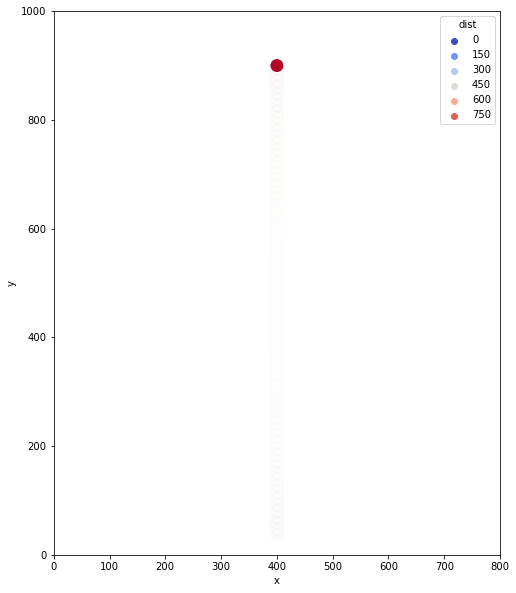

In [28]:
plt.figure(figsize=(8,10))
g = sns.scatterplot(x='x',y='y',hue='dist',palette='coolwarm',data=df,s=200)
g.set(xlim=(0,800),ylim=(0,1000))

[(0.0, 800.0), (0.0, 1000.0)]

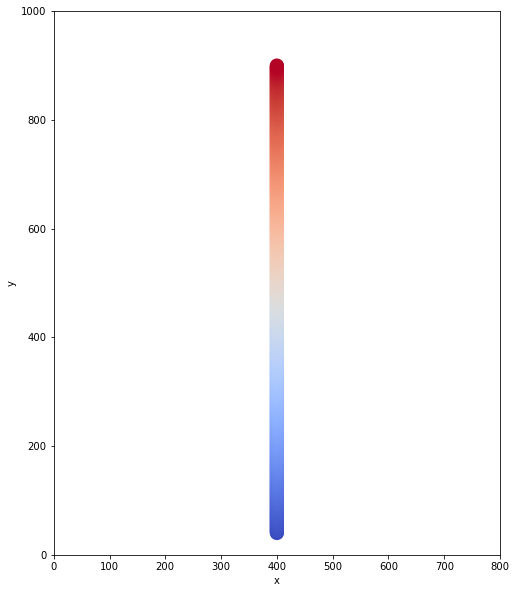

In [36]:
plt.figure(figsize=(8,10))
g=sns.scatterplot(x="x", 
                  y="y", 
                  hue="dist",
                  s=200,
                  data=df,
                  palette="coolwarm",
                  edgecolor="none",
                 legend=False)
g.set(xlim=(0,800),ylim=(0,1000))